# Practical session: Machine Learning Applications 

## Application of machine learning for the discovery of transcription factor binding sites (TFBS)

This tutorial has been developed using the original file and supplement to the manuscript, **A Primer on Deep Learning in Genomics** (*Nature Genetics, 2018*) by James Zou, Mikael Huss, Abubakar Abid, Pejman Mohammadi, Ali Torkamani & Amalio Telentil. [Read the accompanying paper here](https://www.nature.com/articles/s41588-018-0295-5).

Find the original tutorial in the Github site [here](https://github.com/abidlabs/deep-learning-genomics-primer/tree/master) or available as a jupyter notebook in Google Colab: <a href="https://colab.research.google.com/github/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline 

* **How to Use This Tutorial**
* **Introduction to data types**
* **0. Background** 
* **1. Curate the Data**
* **2. Select the Architecture and Train**
* **3. Evaluate**
* **4. Interpret**

## How to Use This Tutorial 

You must be already familar with python notebook files. Python notebook combine live code, visualizations, and explanatory text. 

The notebook is organized into a series of cells. You can modify the Python command and execute each cell as you would a Jupyter notebook. Although it is possible to run all of the cells at once, by choosing **Runtime > Run all** from the menu bar, it is discourage as the practical session it is intented to be execute it chunk by chunk, reading and understanding what is going on. Also, at the end, there are some modifications required for the succesful completion of the practical session.

**ATTENTION**: This is an interactive file, in this case, within a computational enviroment that contains the necessary packages to be executed. If you want to succesfully execute this notebook you will need to run it in the UAB linux computers or install several packages such as:
- scikit-learn
- tensorflow
- seaborn
- matplotlib
- requests
- pandas
- numpy
- biopython

All necessary packages have been previously installed and tested in a computer within a conda environment. The conda configuration has been exported and donwloaded into a file: _deep_learning_env.yaml_, available in github [here](https://raw.githubusercontent.com/JFsanchezherrero/machine_learning_TFBS/refs/heads/main/deep_learning_env.yaml).

You can create a new environment and import the same configuration as it was used before. Read additionals details on how to import and existing environment in the original Anaconda Documentation [site](https://docs.anaconda.com/navigator/tutorials/manage-environments/#importing-an-environment)

To check that the correct environment is activated, load the following libraries

In [1]:
## load some modules to test the environment works appropriately
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import sklearn
import tensorflow as tf

2025-11-19 10:40:17.429227: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 10:40:17.429448: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 10:40:17.462623: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 10:40:18.203758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

## 0. Background

In this practical, we will show how to use deep learning to approach an important problem in functional genomics: **the discovery of transcription-factor binding sites in DNA**.

As we go through this notebook, we will  design a [neural network](https://www.geeksforgeeks.org/neural-networks-a-beginners-guide/?ref=gcse) that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not. Here, the longer **DNA sequences are our *independent variables*** (or *predictors*), while the **positive or negative response of the assay is the *dependent variable* (or *response*)**.

We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

(Spoiler alert: the true regulatory motif is *`CGACCGAACTCC`*. Of course, the neural network doesn't know this.)


## 1. Curate the Data

In order to train the neural network, we must load and preprocess the data, which consists of DNA sequences and their corresponding labels. 

By processing this data, the network will learn to distinguish sequences that bind to the transcription factor from those that do not. 


We will split the data into three different sub-datasets:

**(1) Training dataset**: a dataset used to fit the parameters of a model or to define the weights of connections between neurons of a neural network.

**(2) Validation dataset**: a second dataset used to minimize overfitting. The weights of the network are not adjusted with this data set. After each training cycle, if the accuracy over the training data set increases, but the accuracy over the validation data set stays the same or decreases, then there is overfitting on the neural network.

**(3) Testing dataset**: is a third dataset not included in the training nor validation data sets. After all the training and validation cycles are complete, this dataset is used only for testing the final solution in order to measure the actual predictive power of the neural network on new examples.




![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-01.png?raw=true)

### Let's start the analysis

We start by loading the simulated data from the original repository

In [2]:
SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'
sequences = requests.get(SEQUENCES_URL).text.split('\n')

Library "requests" allow us to connect and download the original txt file hosted in github. 

See details here: https://requests.readthedocs.io/en/latest/user/quickstart/

### Inspect the sequences obtained

In [3]:
type(sequences)

list

In [4]:
## just show the first 5 sequences
sequences[:5]

['CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC',
 'GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGCGTCG',
 'GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTAGCCT',
 'GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGCCCTG',
 'GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATATGGT']

In [5]:
# Another way to just print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


In [6]:
len(sequences)

2001

In [7]:
# This removes empty sequences if any
sequences = list(filter(None, sequences))  
len(sequences)

2000

### Organize the data in tensors

The next  step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, [tensors](https://www.kdnuggets.com/2018/05/wtf-tensor.html)). 

To get each DNA sequence in the form of a matrix, we use **_one-hot encoding_**, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix. 



#### 1) Load and initiate appropriate objects

In [8]:
## 1) Load modules and create objects
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

integer_encoder = LabelEncoder()  ## we just create an object of class LabelEncoder
one_hot_encoder = OneHotEncoder(categories='auto')    ## we just create an object of class OneHotEnconder


The [LabelEncoder](https://scikit-learn.org/1.4/modules/generated/sklearn.preprocessing.LabelEncoder.html) object encodes a sequence of bases as a sequence of integers.


The [OneHotEncoder](https://scikit-learn.org/1.4/modules/generated/sklearn.preprocessing.OneHotEncoder.html) converts an array of integers to a sparse matrix where each row corresponds to one possible value of each feature.

#### 2a) Hot-one encode example sequences

In the cells below, we one-hot encode the simulated DNA sequences, and show an example of what the one-hot encoded sequence looks like:

In [9]:
## See and example for ACGT bases
my_substring = "ACGT"

## print separated by " " for better visualization
print("## Original sequence")
print(" " + " ".join(list(my_substring)))

## Original sequence
 A C G T


In [10]:
## fit the transformation: 
print("## Fit the transformation using LabelEncoder")
integer_encoded = integer_encoder.fit_transform(list(my_substring))
print(integer_encoded)
print(type(integer_encoded))
print("## -- ##\n")

## Fit the transformation using LabelEncoder
[0 1 2 3]
<class 'numpy.ndarray'>
## -- ##



In [11]:
## Reshape or transpose the transformation: 
print("## Reshape/Transpose")
integer_encoded = np.array(integer_encoded).reshape(-1, 1)
print(integer_encoded)
print(type(integer_encoded))    
print("## -- ##\n")

## Reshape/Transpose
[[0]
 [1]
 [2]
 [3]]
<class 'numpy.ndarray'>
## -- ##



In [12]:
## fit the transformation: One-hot encode
print("## Fit the transformation using OneHotEncoder")
one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
print(one_hot_encoded)
print(type(one_hot_encoded))    
print("## -- ##\n")

## Fit the transformation using OneHotEncoder
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
<class 'scipy.sparse._csr.csr_matrix'>
## -- ##



In [13]:
## Create and stacked array
print("## Convert to numpy array, stack label alphabetically and transpose")   
print(np.stack(one_hot_encoded.toarray()).T)   
print("## -- ##\n")

## just to have it around again
print("## Original sequence")
print(" " + " ".join(list(my_substring)))

## Convert to numpy array, stack label alphabetically and transpose
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
## -- ##

## Original sequence
 A C G T


In the cell above, we have **one-hot encode** the simulated DNA sequences, and showed an example of what the one-hot encoded sequence looks like. 

**ATTENTION**: I will create a function for better reproducibility of the results and to later see the same output with different transformations


In [17]:
## create a function with the different visualization of transformations 
def print_example_transformation(my_substring, bases2show=10):
    my_substring = my_substring[:bases2show]
    
    ## print separated by " " for better visualization
    print("## Original sequence")
    print(" " + " ".join(list(my_substring)))

    ## fit the transformation: 
    print("## Fit the transformation using LabelEncoder")
    integer_encoded = integer_encoder.fit_transform(list(my_substring))
    print(integer_encoded)
    print(type(integer_encoded))
    print("## -- ##\n")
    
    ## Reshape or transpose the transformation: 
    print("## Reshape")
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    print(integer_encoded)
    print(type(integer_encoded))    
    print("## -- ##\n")
    
    ## fit the transformation: One-hot encode
    print("## Fit the transformation using OneHotEncoder")
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    print(one_hot_encoded)
    print(type(one_hot_encoded))    
    print("## -- ##\n")

    ## Create and stacked array
    print("## Convert to numpy array, stack label alphabetically and transpose")   
    print(np.stack(one_hot_encoded.toarray()).T)   
    print("## -- ##\n")
    
    print("## Original sequence")
    print(" " + " ".join(list(my_substring)))    

In [16]:
## See and example for ACGT bases
my_substring = "ACGT"
print_example_transformation(my_substring)

## Original sequence
 A C G T
## Fit the transformation using LabelEncoder
[0 1 2 3]
<class 'numpy.ndarray'>
## -- ##

## Reshape
[[0]
 [1]
 [2]
 [3]]
<class 'numpy.ndarray'>
## -- ##

## Fit the transformation using OneHotEncoder
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
<class 'scipy.sparse._csr.csr_matrix'>
## -- ##

## Convert to numpy array, stack label alphabetically and transpose
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
## -- ##

## Original sequence
 A C G T


In [18]:
## See another example for the first bases of the first sequence:
my_substring = sequences[0][:10]
print_example_transformation(my_substring)

## Original sequence
 C C G A G G G C T A
## Fit the transformation using LabelEncoder
[1 1 2 0 2 2 2 1 3 0]
<class 'numpy.ndarray'>
## -- ##

## Reshape
[[1]
 [1]
 [2]
 [0]
 [2]
 [2]
 [2]
 [1]
 [3]
 [0]]
<class 'numpy.ndarray'>
## -- ##

## Fit the transformation using OneHotEncoder
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10 stored elements and shape (10, 4)>
  Coords	Values
  (0, 1)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 0)	1.0
  (4, 2)	1.0
  (5, 2)	1.0
  (6, 2)	1.0
  (7, 1)	1.0
  (8, 3)	1.0
  (9, 0)	1.0
<class 'scipy.sparse._csr.csr_matrix'>
## -- ##

## Convert to numpy array, stack label alphabetically and transpose
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
## -- ##

## Original sequence
 C C G A G G G C T A


In [19]:
## now another example using the argument of the function
print_example_transformation(sequences[10], bases2show=30)

## Original sequence
 C C C G T T G C C T C A T C T A T T T T A G T T C T C G A C
## Fit the transformation using LabelEncoder
[1 1 1 2 3 3 2 1 1 3 1 0 3 1 3 0 3 3 3 3 0 2 3 3 1 3 1 2 0 1]
<class 'numpy.ndarray'>
## -- ##

## Reshape
[[1]
 [1]
 [1]
 [2]
 [3]
 [3]
 [2]
 [1]
 [1]
 [3]
 [1]
 [0]
 [3]
 [1]
 [3]
 [0]
 [3]
 [3]
 [3]
 [3]
 [0]
 [2]
 [3]
 [3]
 [1]
 [3]
 [1]
 [2]
 [0]
 [1]]
<class 'numpy.ndarray'>
## -- ##

## Fit the transformation using OneHotEncoder
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 30 stored elements and shape (30, 4)>
  Coords	Values
  (0, 1)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (4, 3)	1.0
  (5, 3)	1.0
  (6, 2)	1.0
  (7, 1)	1.0
  (8, 1)	1.0
  (9, 3)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 3)	1.0
  (13, 1)	1.0
  (14, 3)	1.0
  (15, 0)	1.0
  (16, 3)	1.0
  (17, 3)	1.0
  (18, 3)	1.0
  (19, 3)	1.0
  (20, 0)	1.0
  (21, 2)	1.0
  (22, 3)	1.0
  (23, 3)	1.0
  (24, 1)	1.0
  (25, 3)	1.0
  (26, 1)	1.0
  (27, 2)	1.0
  (28, 0)	1.0
  (29, 1)	1.0
<class 's

Now, loop for each sequence and encode the simulated DNA sequence as desired

#### 2b) Hot-one encode all sequences 

Now, it is time to one-hot encode all sequences available for later processing.

In [20]:
# just load modules and create objects again just in case
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder(categories='auto') 

In [21]:
## 2) one-hot encode the simulated DNA sequence
input_features = []
for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

## convert to numpy array
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)

In [22]:
## show another example of the encoding
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
## inspect
input_features[1]

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], shape=(50, 4))

In [24]:
type(input_features)

numpy.ndarray

In [25]:
len(input_features)

2000

In [26]:
type(input_features)

numpy.ndarray

In [27]:
input_features.size

400000

In [28]:
input_features.shape

(2000, 50, 4)

In [29]:
input_features.ndim

3

The _input_features_ is the object containing the information from DNA sequences one-hot encoded to use as input for the neural network. It is stored as tensor (numpy array)

#### 3) Get information for each sequence

Similarly, we can go ahead and load the labels (_response variables_). In this case, the labels are structured as follows: 
- a "1" indicates that a protein bound to the sequence, while
- a "0" indicates that the protein did not.

While we could use the labels as a vector, it is often easier to similarly **one-hot encode the labels**, as we did the features. We carry out that here:

In [30]:
## download information from original website
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

print(labels[:25])

['0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1']


In [31]:
len(labels)

2000

In [32]:
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


### Prepare the training and test sets

We also go ahead and split the data into training and test sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training. 

At a later step, we will further partition the training set into a training and validation set.

We will be using function [train_test_split](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) that quickly splits arrays or matrices into random train and test subsets.






Provided parameters are:
- **Arrays**: Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes. We provide **input_features** and **input_labels**
- **test_size**: Value between 0.0 and 1.0 that represents the proportion of the dataset to include in the test split.
- **random_state**: Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls

Return values are list containing train-test split of inputs.

In [33]:
## load package and split the input information: sequences and labels, as tensors
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=123)

**ATTENTION**: Create a simple function to check multiple parameters of tensors created

In [34]:
def check_arrays(array_given):
    print("## Type:")
    print(type(array_given))
    
    print("## Number dimensions:")
    print(array_given.ndim)
    
    print("## Shape:")
    print(array_given.shape)

    print("## Size:")
    print(array_given.size)
    

In [35]:
check_arrays(train_features)

## Type:
<class 'numpy.ndarray'>
## Number dimensions:
3
## Shape:
(1500, 50, 4)
## Size:
300000


In [36]:
check_arrays(train_labels)

## Type:
<class 'numpy.ndarray'>
## Number dimensions:
2
## Shape:
(1500, 2)
## Size:
3000


In [37]:
check_arrays(test_features)

## Type:
<class 'numpy.ndarray'>
## Number dimensions:
3
## Shape:
(500, 50, 4)
## Size:
100000


In [38]:
check_arrays(test_labels)

## Type:
<class 'numpy.ndarray'>
## Number dimensions:
2
## Shape:
(500, 2)
## Size:
1000


## 2. Select the Architecture and Train

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-49.png?raw=true)

Next, we choose a neural network architecture to [train the model](https://www.geeksforgeeks.org/implementing-neural-networks-using-tensorflow/). In this tutorial, we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of a transcription factor binding site). 

We will use the deep learning library `Keras`. As of 2017, `Keras` has been integrated into `TensorFlow`,  which makes it very easy to construct neural networks. We only need to specify the kinds of layers we would like to include in our network, and the dimensionality of each layer. 

### Naïve example

First, you can try using the linear model, since the neural network basically follows the same ‘math’ as regression you can create a linear model using a neural network as follows :

In [39]:
## Load modules
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

In [40]:
linear_model = Sequential()
linear_model.add(Dense(units=1, input_shape=[train_features.shape[1]]))

linear_model.summary()

/home/UAB/1637748/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-19 11:29:14.473259: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 0 (0.00 B)

### CNN Model

But this is basically a linear model, what if your dataset is a bit more complex, and the relations between the features are much more diverse and you want a non-linear model? What do you need? The answer is [Activation Functions](https://www.geeksforgeeks.org/activation-functions-neural-networks/). This is where neural networks truly start to shine. 

We will not go in-depth about activation functions here but basically, these add/introduce non-linearity to our model, the more you use them the more complex patterns our model can find. An activation function determines the output of a neuron in a neural network by adding non-linearity, enabling the network to learn complex patterns from the data.



The CNN we generate in this example consists of the following layers:

- _Conv1D_: We define our convolutional layer to have 32 filters of size 12 bases.

- _MaxPooling1D_: After the convolution, we use a pooling layer to down-sample the output of the each of the 32 convolutional filters. Though not always required, this is a typical form of non-linear down-sampling used in CNNs.

- _Flatten_: This layer flattens the output of the max pooling layer, combining the results of the convolution and pooling layers across all 32 filters. 

- _Dense_: The first Dense tensor creates a layer (dense_1) that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors, and the second Dense function converges the tensors into the output layer (dense_2) that consists of the two possible response values (0 or 1).

We can see the details of the architecture of the neural network we have created by running `model.summary()`, which prints the dimensionality and number of parameters for each layer in our network. 

In [41]:
model_CNN = Sequential()
model_CNN.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model_CNN.add(MaxPooling1D(pool_size=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(16, activation='relu')) ## relu (rectified linear unit) 
model_CNN.add(Dense(2, activation='softmax'))

/home/UAB/1637748/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
(train_features.shape[1], 4)

(50, 4)

In [43]:
type(model_CNN)

keras.src.models.sequential.Sequential

In Keras after you create your model, you need to ‘compile’ other parameters for it, like it’s shown below. This is kind of like us setting all the parameters for our model.



In [44]:
# adam optimizer works pretty well for
# all kinds of problems and is a good starting point
model_CNN.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])

## as metrics we required the binary_accuraccy as we are have a categorical variable.
## We might use the mean absolute error if we have a continuous variable


In [45]:
model_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 39, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,226 (24.32 KB)

 Trainable params: 6,226 (24.32 KB)

 Non-trainable params: 0 (0.00 B)

Now, we are ready to go ahead and train the neural network. We will further divide the training set into a training and validation set. 

In [47]:
history_CNN = model_CNN.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)

Find additional information for the model.fit function in the original website [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

We will train only on the reduced training set, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

Inspect the keras model generated

In [48]:
history_CNN.params

{'verbose': 0, 'epochs': 50, 'steps': 36}

In [49]:
type(history_CNN.history)

dict

In [50]:
history_CNN.model

<Sequential name=sequential_1, built=True>

Find the data stored within the history.history object. Show it as a dataframe

In [51]:
pd.DataFrame.from_dict(history_CNN.history).head()

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,1.0,0.001070,0.970667,0.102508
1,1.0,0.001015,0.970667,0.100711
2,1.0,0.001003,0.970667,0.100318
3,1.0,0.000948,0.970667,0.102962
4,1.0,0.000874,0.973333,0.104996


Now, lets find out about the performance of the model by plotting the accuracy and loss curve which are two common tools we use to understand how well a machine learning model is learning and getting better over time. In the simplest terms, they help us evaluate the model's performance during training. 

On the one hand, the accuracy curve records how accurate the model’s predictions are on the given data, while the loss curve records the actual difference between the model’s prediction and the actual true output. 

#### LOSS Curve

The loss curve, or training loss curve, gives us insights into how the model's performance improves over time by measuring the error (or dissimilarity) between its predicted output and the true output. The loss represents how far off the model's predictions are from the actual values. 

By minimizing the loss, the model aims to make its predictions as close as possible to the true values. 
Put simply: the loss curve shows us how the model's error decreases as it learns, which indicates an improvement in its performance.


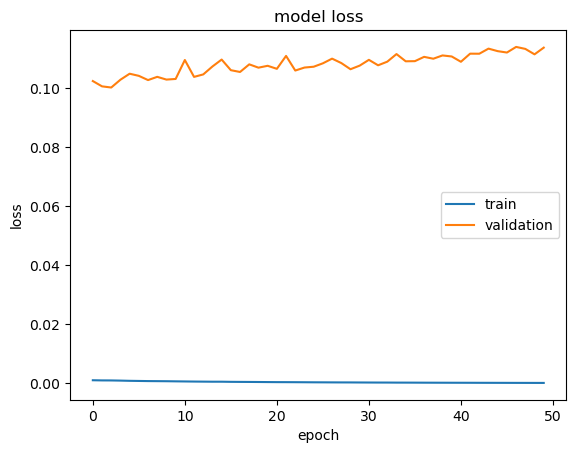

In [52]:
## plot the results training as LOSS curve
plt.figure()
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#### Accuracy curve

Similarly, we can plot the accuracy of our neural network on the binary classification task. The metric used in this example is the _binary accuracy_, which calculates the proportion of predictions that match labels or response variables. Other metrics may be used in different tasks -- for example, the _mean squared error_ is typically used to measure the accuracy for continuous response variables (e.g. polygenic risk scores, total serum cholesterol level, height, weight and systolic blood pressure).

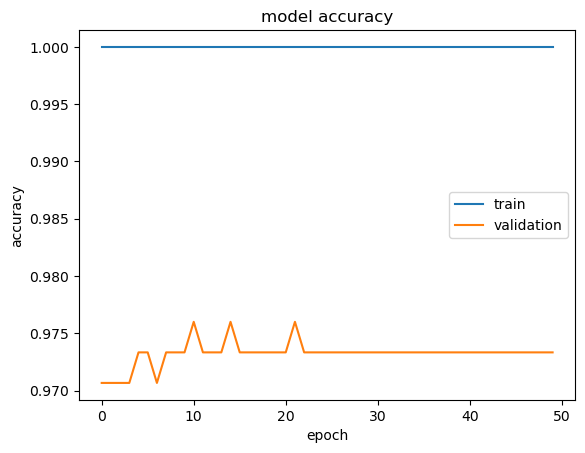

In [53]:
plt.figure()
plt.plot(history_CNN.history['binary_accuracy'])
plt.plot(history_CNN.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Reading [here](https://wandb.ai/mostafaibrahim17/ml-articles/reports/A-Deep-Dive-Into-Learning-Curves-in-Machine-Learning--Vmlldzo0NjA1ODY0 ) the guide on accuracy and loss curves for a better understanding of the interpretation of this plots


## 3. Evaluate

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-12.png?raw=true)

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we evaluate the model on the test set and plot the results as a confusion matrix. Nearly every test sequence should be correctly classified.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion matrix:
 [[243   4]
 [  5 248]]


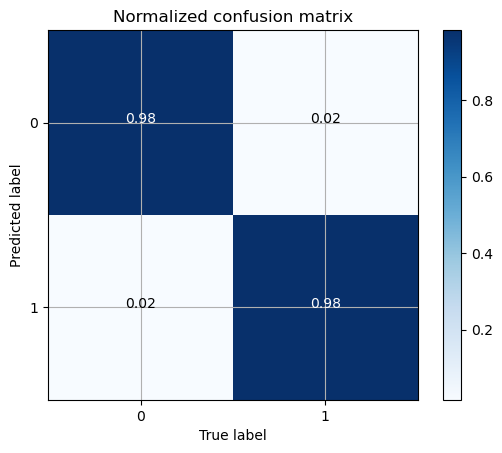

In [54]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model_CNN.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

Evaluate the model on the test data and compute the accuracy and loss of the predicted and actual presence of transcription binding sites in each sequence.

In [55]:
test_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], shape=(500, 2))

In [56]:
predicted_labels

array([[1.0000000e+00, 4.0296737e-13],
       [9.9998593e-01, 1.4096890e-05],
       [1.0000000e+00, 1.0462327e-09],
       ...,
       [9.9997997e-01, 1.9987281e-05],
       [2.0830270e-11, 1.0000000e+00],
       [6.7592969e-06, 9.9999321e-01]], shape=(500, 2), dtype=float32)

In [57]:
loss_and_metrics = model_CNN.evaluate(train_features, train_labels)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.9933 - loss: 0.0286   
Loss =  0.028576267883181572
Accuracy =  0.9933333396911621


## 4. Evaluate the performance by understanding and tuning the parameters

By tuning different parameters in simple machine learning models we can get to understand how it works and how to unlock the full potential of it.

I will create several functions for the reproducibility and usability of the code, show how to use them and finally, ask some questions to address your research.

In [68]:
#######################################
## create CNN model
#######################################
def get_cnn_model(train_f, option=1):
    if option==1:
        ## create the CNN model use before
        model2return = Sequential()
        model2return.add(Conv1D(filters=32, kernel_size=12, 
                         input_shape=(train_f.shape[1], 4)))
        model2return.add(MaxPooling1D(pool_size=4))
        model2return.add(Flatten())
        model2return.add(Dense(16, activation='relu')) ## relu (rectified linear unit) 
        model2return.add(Dense(2, activation='softmax'))
    else:
        ## add another model
        model2return = Sequential()
        model2return.add(Conv1D(filters=40, kernel_size=20, 
                         input_shape=(train_f.shape[1], 4)))
        model2return.add(MaxPooling1D(pool_size=4))
        model2return.add(Flatten())
        model2return.add(Dense(16, activation='relu')) ## relu (rectified linear unit) 
        model2return.add(Dense(2, activation='softmax'))

    ## compile model
    model2return.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])

    return model2return
#######################################

In [59]:
## test function to produce the CNN model of study or other options
test_model = get_cnn_model(train_f=train_features, option=1)
test_model.summary()

/home/UAB/1637748/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 39, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,226 (24.32 KB)

 Trainable params: 6,226 (24.32 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
## test function to produce the CNN model of study or other options
test_model = get_cnn_model(train_f=train_features, option = 2)
test_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 31, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 280)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         4,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,770 (30.35 KB)

 Trainable params: 7,770 (30.35 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
#######################################
## create plots model
#######################################
def create_plots(history2use_here, cm_given):
    
    # Initialise the subplot function using number of rows and columns
    figure, axis = plt.subplots(1, 3, figsize=(12, 6))    
    
    ## plot the results training as LOSS curve
    axis[0].plot(history2use_here.history['loss'])
    axis[0].plot(history2use_here.history['val_loss'])
    axis[0].set_title('model loss')
    axis[0].set_ylabel('loss')
    axis[0].set_xlabel('epoch')
    axis[0].legend(['train', 'validation'])
    
    ## plot accuracy curve
    axis[1].plot(history2use_here.history['binary_accuracy'])
    axis[1].plot(history2use_here.history['val_binary_accuracy'])
    axis[1].set_title('model accuracy')
    axis[1].set_ylabel('accuracy')
    axis[1].set_xlabel('epoch')
    axis[1].legend(['train', 'validation'])
    
    #figure.legend(['train', 'validation'], loc='outside right upper')

    ## plot the confusion matrix for True/False observed/predicted
    axis[2].imshow(cm_given, cmap=plt.cm.Blues)
    axis[2].set_title('Normalized confusion matrix')
    axis[2].set_xlabel('True label')
    axis[2].set_ylabel('Predicted label')
    axis[2].set_xticks([0, 1]); 
    axis[2].set_yticks([0, 1])
    axis[2].grid('off')
    for i, j in itertools.product(range(cm_given.shape[0]), range(cm_given.shape[1])):
        axis[2].text(j, i, format(cm_given[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if cm_given[i, j] > 0.5 else 'black')

    
    # Combine all the operations and display
    plt.show()

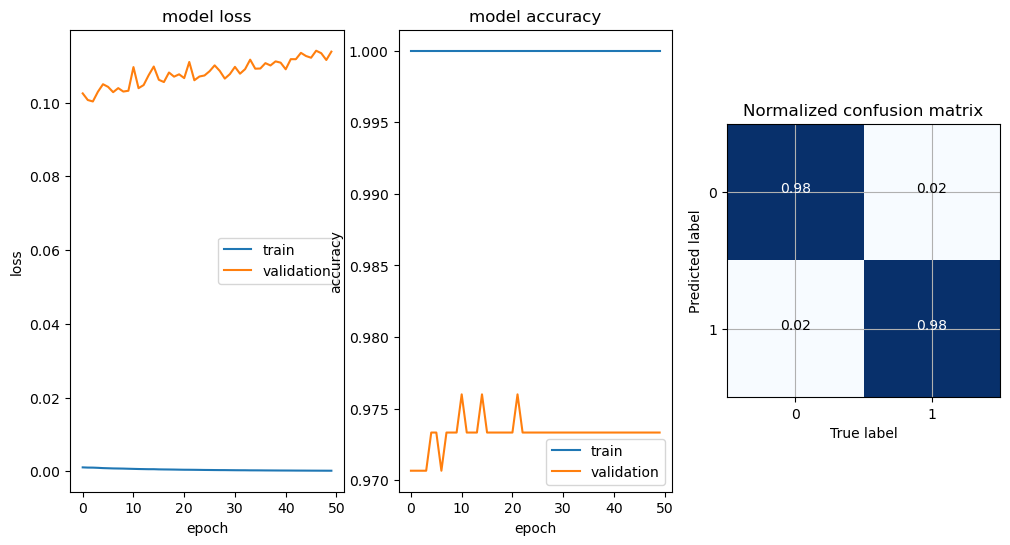

In [61]:
# test example function to plot at once the three plots of interest to evaluate the performance
create_plots(history_CNN, cm_given=cm)

In [7]:
#######################################
## create a function to reproduce the model many times
#######################################
def example_CNN(features2used, labels2use, 
                random_state_int=123, test_size_float=0.25, model_option=1,
                epochs2use=5, verb_2use=0, val_2use=0.25): ## set defaults

    from sklearn.model_selection import train_test_split

    
    ## split the dataset
    train_features2use, test_features2use, train_labels2use, test_labels2use = train_test_split(
        features2used, labels2use, test_size=test_size_float, random_state=random_state_int)

    if verb_2use>0:
        check_arrays(train_features2use)
        check_arrays(test_features2use)
        check_arrays(train_labels2use)
        check_arrays(test_labels2use)
    
    ## create the model
    model2use = get_cnn_model(train_f=train_features2use, option=model_option)

    if verb_2use>0:
        print(model2use.summary())
        print(model2use)

    ## train
    history2use = model2use.fit(train_features2use, train_labels2use, 
                    epochs=epochs2use, verbose=verb_2use, validation_split=val_2use)
    
    
    ## evaluate
    predicted_labels2use = model2use.predict(np.stack(test_features2use))
    cm2use = confusion_matrix(np.argmax(test_labels2use, axis=1), 
                          np.argmax(predicted_labels2use, axis=1))
    cm2use = cm2use.astype('float') / cm2use.sum(axis = 1)[:, np.newaxis]

    print('Confusion matrix:\n',cm2use)

    ## create plots
    create_plots(history2use, cm2use)

    loss_and_metrics2use = model2use.evaluate(train_features2use, train_labels2use)
    if verb_2use>0:
        print('Loss = ',loss_and_metrics2use[0])
        print('Accuracy = ',loss_and_metrics2use[1])

    return loss_and_metrics2use


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion matrix:
 [[0.92307692 0.07692308]
 [0.44664032 0.55335968]]


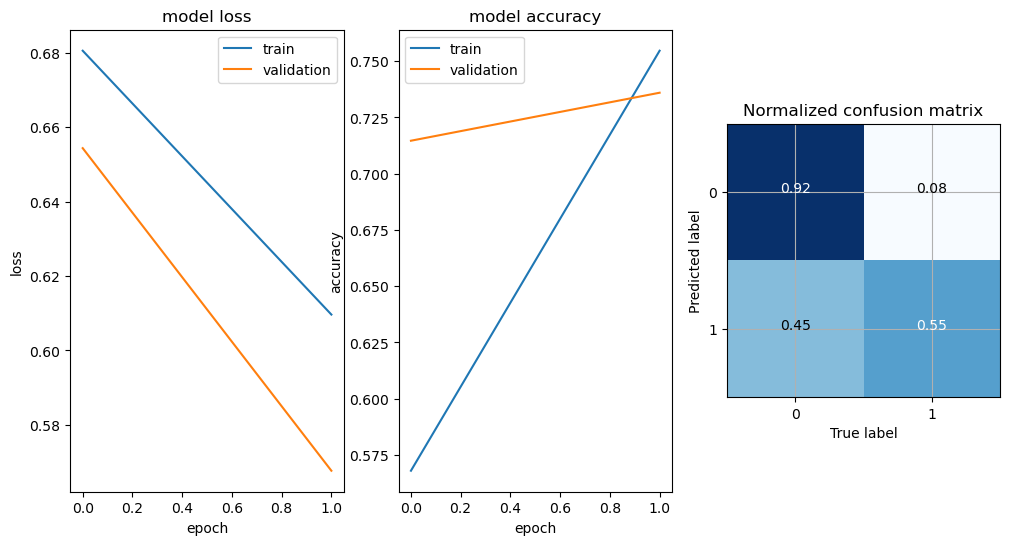

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - binary_accuracy: 0.7533 - loss: 0.5570


[0.5569645762443542, 0.753333330154419]

In [63]:
## usage example
example_CNN(features2used=input_features, labels2use=input_labels, epochs2use=2)

## Questions to address:

- Find what is the effect of the verbose parameter in the _model.fit()_ [or supplied as _verb_2use_ the _example_CNN()_]
- Test the effect of applying a more simple model [Hint: reduce layers of the model]
- Test the effect of epoch in the prediction: 2, 5, 10, 25, 50, 100, 1000
- Test the effect of applying a different test/train set partition


In [ ]:
Al ir cambiando los parametros en el modelo han habido cambios en las gráficas y resultados.

## 5. Interpret the results

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-31.png?raw=true)

Your results so far should allow you to conclude that the neural network is quite effective in learning to distinguish sequences that bind the protein from sequences that do not. But can we understand _why_ the neural network classifies a training point in the way that it does? To do so, we can compute a simple _saliency map_, which is the gradient of the model's prediction with respect to each individual nucleotide. 

In other words, the saliency maps shows how the output response value changes with respect to a small changes in input nucleotide sequence. All the positive values in the gradients tell us that a small change to that nucleotide will change the output value. Hence, visualizing these gradients for a given input sequence, should provide some clues about what nucleotides form the binding motive that we are trying to identify.

In [ ]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
    @tf.function
    def compute_gradients(x):
        with tf.GradientTape() as tape:
            tape.watch(x)
            logits = model(x)
            prob = logits[:, 1]  # Assuming binary classification, change the index if needed
        gradients = tape.gradient(prob, x)
        return gradients

    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients(x_value)
    gradients = tf.where(gradients == None, tf.zeros_like(gradients), gradients)
    sal = tf.reduce_sum(gradients * x, axis=2)
    sal = tf.clip_by_value(sal, clip_value_min=0, clip_value_max=tf.reduce_max(sal))
    return sal.numpy()

In [ ]:
## Positive sequence
sequence_index = 1999  
sal = compute_salient_bases(model_CNN, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal[0])), sal[0])
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal[0])), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (orange indicates the actual bases in motif)');

In [ ]:
# negative sequence
sequence_index = 0  
sal = compute_salient_bases(model_CNN, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal[0])), sal[0])
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal[0])), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the negative sequences'
          ' (orange indicates the actual bases in motif)');

The results above should show high saliency values for the bases _CGACCGAACTCC_ appearing in the DNA sequence. If you recall from the top of the document, this is exactly the motif that we embedded in the positive sequences! The raw saliency values may be non-zero for other bases as well -- the gradient-based saliency map method is not perfect, and there other more complex interpretation methods that are used in practice to obtain better results.  

Furthermore, we may explore other architectures for our neural network to see if we can improve performance on the validation dataset. For example, we could choose different _hyper-parameters_, which are variables that define the network structure (e.g. the number of dense or convolutional layers, the dimensionality of each layer, etc.) and variables that determine how the network is trained (e.g. the number of epochs, the learning rate, etc.). Testing different hyper-parameter values or performing a hyper-parameter search grid are good practices that may help the deep learning procedure to obtain a clearer signal for classifying sequences and identifying the binding motif.

## Acknowledgements 

Thanks to Julia di lulio and Raquel Dias for helpful comments and suggestions in preparing this notebook.

## References and examples
- https://www.kdnuggets.com/2018/05/wtf-tensor.html
- https://www.geeksforgeeks.org/implementing-neural-networks-using-tensorflow/ 
- https://www.geeksforgeeks.org/neural-networks-a-beginners-guide/?ref=gcse
- https://wandb.ai/mostafaibrahim17/ml-articles/reports/A-Deep-Dive-Into-Learning-Curves-in-Machine-Learning--Vmlldzo0NjA1ODY0
- https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
- https://www.bmc.com/blogs/keras-neural-network-classification/

# GitHub Repository

If you found this tutorial helpful, kindly star the [associated GitHub repo](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) so that it is more visible to others as well!